<a href="https://colab.research.google.com/github/CarolineAndradeR/Python/blob/master/amostragem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Amostragem**


> Quando temos grandes conjuntos de dados, fazemos recortes (seleção) desses dados.






In [ ]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install statsmodels
!pip install sklearn

In [ ]:
#Iniciando montagem do drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

arq_dados_imoveis = '/content/drive/MyDrive/dados_imoveis_cwb.csv'
df_dados_imoveis = pd.read_csv(arq_dados_imoveis, sep='\t')
df_dados_imoveis

In [ ]:
df_dados_imoveis.tail(25)

# **Obtenção de uma amostra de referência**

*   **Amostragem** - Análise com base em todo o conjunto de dados - Dividir os dados semelhantes em intervalos menores
*   **Dados Piloto** - Análise com base na amostragem dos dados - Um recorte da amostragem.

In [ ]:
#QCUT - passar o atributo (coluna), o número de estraros, qual o indentificador de cada estratos.
#Divisão da categoria de imoveis de acordo com o seu valor.
df_dados_imoveis['categoria'] = pd.qcut(df_dados_imoveis['preco'], 4, labels = ['D', 'C', 'B', 'A'])

df_dados_imoveis

In [ ]:
dados_piloto = df_dados_imoveis.agg(media_preco = pd.NamedAgg('preco', 'mean'),
                                dp_preco = pd.NamedAgg('preco', 'std'),
                                N = pd.NamedAgg('preco', 'count'))
dados_piloto

In [ ]:
#Dados Piloto
dados_piloto_categoria = df_dados_imoveis.groupby('categoria') \
                        .agg(media_preco = pd.NamedAgg('preco', 'mean'),
                            dp_preco = pd.NamedAgg('preco', 'std'),
                            N = pd.NamedAgg('preco', 'count')) \
                        .reset_index()
dados_piloto_categoria['percent'] = dados_piloto_categoria['N'] / sum(dados_piloto_categoria['N'])
dados_piloto_categoria



* Garatir que os dados sejam representativos, ou seja, que pegue uma quantidade relevante com base no conjunto geral dos dados.
*   Não precisamos pegar extamente o valor que vai ser gerado na sugestão, mas também não pode ser menor que a quantidade de linhas da sugestão gerada.



In [16]:
#Sugestão de quantidade de linhas para a amostragem
#Formula continua, são os dados que não conseguimos pegar com exatidão por ser infinito (não conseguir contar)
def formula_amostra_continua(N, S, Z, ME):
  n = (Z**2 * S**2 * N) / ((ME**2 * (N-1)) + (Z**2 * S**2))
  return int(n)

#Formula discreta, dados que consiguimos contar, dados finitos
def formula_amostra_discreta(N, Z, ME):
  n = (Z**2 * 0.25 * N) / ((ME**2 * (N-1)) + (Z**2 * 0.25))
  return int(n)



#Parametros
N = dados_piloto.loc['N'] #dados da base piloto
Z = 1.96   #Nível de confiança de 96%
S = dados_piloto.loc['dp_preco']   #Desvio-padrão piloto, dados que vão ser usado
ME = 50000  #Margem de erro, margem que pode estar para mais ou para menos

#Tamanho da amostra
n = formula_amostra_continua(N, S, Z, ME)
n

713

In [20]:
import random as rd

n = 1500 #Seleciona 1500 imoveis como amostragem
N = 4470 #Quantidade de linha da base de dados

#Seleção de linhas aleatórias
linhas_aleatoria = rd.sample(range(1, N+1), n)

#Filtra os dados
#INDEX - Seleciona os dados do DataFreme
#ISIN - Verifica se os index estão dentro da lista indicada (linhas_aleatoria)
dados_amostra = df_dados_imoveis[df_dados_imoveis.index.isin(linhas_aleatoria)]
dados_amostra.shape

(1500, 8)

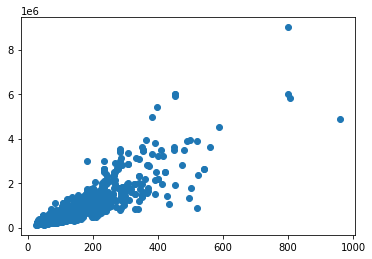

In [21]:
#Visualização de como os dados estão distribuidos na amostragem.
import matplotlib.pyplot as plt

plt.scatter(dados_amostra['area'], dados_amostra['preco'])

In [ ]:
#Seleção dos dados de amostragem mais orientada
#SAMPLE - Seleção da quantidade que passamos como parametro
dados_amostra_simples = df_dados_imoveis.sample(n=1500)
dados_amostra_simples

<AxesSubplot:>

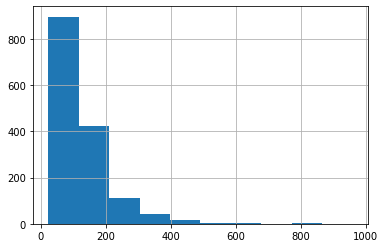

In [24]:
#Visualização da distribuição dos dados com base no SAMPLE
#BINS - Intervalo em que os dados vão ser exibidos (eixo)

dados_amostra_simples['area'].hist(bins=10)
#Imoveis com menor valor está em número maior.

**Amostra estartificada** - Modelo ML

In [26]:
#model_selection - seleção de dados aleatória
from sklearn.model_selection import train_test_split

#Vai pegar apenas 1500 e o restante dos dados fica para treina o modelo
#random_state=1245 - garatir a forma de como os dados foram escolhidos
#stratify - grupos, garatir que todos os bairros esteja participando da amostragem
n = 1500
treino_amostra, teste_amostra = train_test_split(df_dados_imoveis,
                                                 test_size = n,
                                                 random_state=1245,
                                                 stratify=df_dados_imoveis['bairro'])
print(f"Dados de treino: {treino_amostra.shape}")
print(f"Dados de teste: {teste_amostra.shape}")

Dados de treino: (2970, 8)
Dados de teste: (1500, 8)


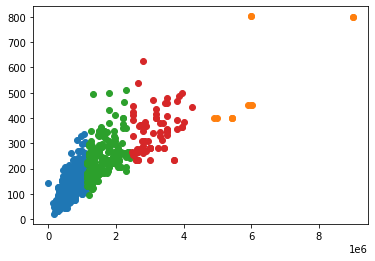

In [30]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot

#Carga de dados
X = treino_amostra.copy()

#Conversão para valores numericos
#Ele transforma bairro em coluna e para cada linha (id do imovel) é peenchido com o 1 se for aquele bairro daquela imovel
dummies = pd.get_dummies(X.bairro)

#Concatenação com o DataFreme orginal com a transformação dos bairros e gerar um DataFreme novo 
merged = pd.concat([X, dummies], axis='columns')

#Apaga colunas que não vão ser utilizadas (dados do tipo texto)
#Bairro com o tipo texto
del merged['bairro']
del merged['categoria']

#Apagar dados que contém NaN
X = merged.dropna().to_numpy()

#Modelo de clusterização divido em 4
model = AgglomerativeClustering(n_clusters=4)

#Validar se a hipótese de divir em 4 clusters é realmente valida

#Treinamento do modelo de predição dos clusters
yhat = model.fit_predict(X)

#Recuperação dos id dos clusters
clusters = unique(yhat)

#Plota uma aproximação dos clusters
for cluster in clusters:
  #Recupera a linha atual do cluster
  row_ix = where(yhat == cluster)
  #plota as instâncias
  pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

#Exibição do gráfico
pyplot.show()